### Work-in-progress

In [253]:
import os
import csv
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Stats models 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
warnings.filterwarnings('ignore')

##### Tasks
1. Data understanding and preprocessing
2. Create a train and test set (for subsequent machine learning)
3. Data cleaning and feature engineering
   * read up about for feature engineering
4. Visualization
5. Machine Learning

##### Important Features to Notice
`loan_status` = can exclude "Current" or "In Grace Period" since we cannot tell if the loan will be paid or defaulted
`issue_d` = loan issue date (month)
`term` = only 36 or 60 months, can treat as categorical data (can try changing and not changing)

In [2]:
# Reading in the 1.68 GB data file.
df = pd.read_csv("../dataset/lendingclub/accepted_2007_to_2018Q4.csv")

In [ ]:
# Look at the data that are not numerical
df.select_dtypes(include=["object"])

In [ ]:
# Remove the last two rows of the data frame.
df = df.iloc[:-2, :]

Identify the rows and features to drop:
1. Drop `loan_status` which are not `Fully Paid` or `Charged Off`
2. Contain high percentage of missing values
3. Multicollinearity
4. Features not associated with loan status

Since we're going to use this dataset to do prediction of whether a loan is fully paid or charged off/defaulted, we can drop the events where the loans are still in place: current and in grace period or late. 

In [ ]:
# Look at cross tabulation between the feature term and target loan_status
pd.crosstab(df["term"], df["loan_status"])

# Subset data frame based on loan status - Charged Off and Fully Paid
mapping = {"Does not meet the credit policy. Status:Charged Off": "Charged Off",
           "Default": "Charged Off",
           "Does not meet the credit policy. Status:Fully Paid": "Fully Paid"}

df["loan_status"] = df["loan_status"].replace(mapping)

df = df[~df["loan_status"].isin(["Current", 
                                 "In Grace Period", 
                                 "Late (16-30 days)",
                                 "Late (31-120 days)"])]

pd.crosstab(df["term"], df["loan_status"])

In [ ]:
# Determine the percentage of missing values from each feature.
ms_values_count = df.isnull().sum()
ms_values_perc = 100 * ms_values_count / len(df)

ms_values_df = pd.DataFrame({"ms_values_count": ms_values_count,
                             "ms_values_perc": ms_values_perc})
ms_values_df.sort_values("ms_values_perc", ascending=False, inplace=True)
ms_values_df[ms_values_df["ms_values_perc"] > 0]

# Remove features with more than 50% missing values. 
feat_rm = list(ms_values_df[ms_values_df["ms_values_perc"] > 50].index)
df.drop(feat_rm, axis=1, inplace=True)

# `id` should not be associated with loan status
# `policy_code` only has one value
# `out_prncp` and `out_prncp_inv` mainly just a single value
df.drop(["id", "policy_code", "out_prncp", "out_prncp_inv"], axis=1, inplace=True)

# Drop rows that contain missing values.
df.dropna(axis=0, how="any", inplace=True)

For numerical data, we can see if there are any highly correlated features. We can then remove features that are highly correlated. 

VIF gives you a measure of how much the variance of an estimated regression coefficient increases due to the presence of correlated features. 

* VIF > 5 --> the variance of estimated regression coefficient increases largely due to the presence of that feature. 
* VIF = 1 --> the variance of estimated regression coefficient does not increase despite the presence of that feature.

In [ ]:
# Check if there is already features that are one-hot encoded.
for col in df.columns:
    if set(df[col].unique()) == {0, 1}:
        print(col)

In [ ]:
# Correlation matrix
corrmat = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corrmat, xticklabels=True, yticklabels=True, cmap='RdYlGn');

In [251]:
# Return a list of tuples that contain the pair of highly correlated features.
def find_corr_pairs(df, thresh=0.8):
    corr_pairs = []
    for row in corrmat.index:
        for col in corrmat.columns:
            if (row!=col) and (corrmat.loc[row, col] >= thresh):
                corr_pairs.append((row, col))
    return corr_pairs

# Setting pearson correlation threshold as 0.8
corr_pairs = find_corr_pairs(df, thresh=0.8)

In [ ]:
# Only requires the numerical features.
# Same number of features as used in the correlation matrix.
df_num = df.select_dtypes(include="number")

# This takes a little while as there are >900,000 rows. 
# To calculate the VIF for each feature using a subset of the dataset. 
df_num_subset = df_num.sample(10000)

for i, k in enumerate(df_num_subset.columns):
    print(k, ": ", round(variance_inflation_factor(df_num_subset.values, i), 2), sep="")

There are a number of features with very high VIF values. We shall set the threshold for VIF to be 5, and pick out the columns with VIF value more than the set threshold. 

The columns will then be matched against the correlation list to see if they match.

The correlation matrix can be calculated again to see if there are any more highly correlated features.

In [ ]:
vif_threshold = 5

dropped = True
feat_to_drop = []

# VIF is re-calculated each time a feature is dropped.
# Iteration completed when all VIF < 5.
while dropped:
    dropped = False
    
    # Select a random subset of sample on each iteration to calculate the VIF
    df_num_subset = df_num.sample(10000)

    vif_list = []
    for i, k in enumerate(df_num_subset.columns): 
        vif_list.append(round(variance_inflation_factor(df_num_subset.values, i), 3))
    
    # Match the VIF to the feature
    vif_series = pd.Series(vif_list, index=df_num_subset.columns)
    vif_series = vif_series.sort_values(ascending=False)
    
    if vif_series.iloc[0] > vif_threshold:
        
        # Save the features that are dropped
        feat_to_drop.append(vif_series.index[0])
        print("feature dropped: ", vif_series.index[0])
        
        # Drop the feature when the VIF > 5
        df_num.drop(vif_series.index[0], axis=1, inplace=True)
        dropped = True

Train a random forest model with just the numerical values to get an idea of what the accuracy score looks like now. 

In [236]:
# Random Forest with just numerical features.
features = df.select_dtypes(include="number").drop(feat_to_drop, axis=1)
target = df["loan_status"]

x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=1988)

x_train = pd.DataFrame(x_train, columns=features.columns)
x_test = pd.DataFrame(x_test, columns=features.columns)

rf = RandomForestClassifier(random_state=1988)
rf.fit(x_train, y_train);

y_pred = rf.predict(x_test)

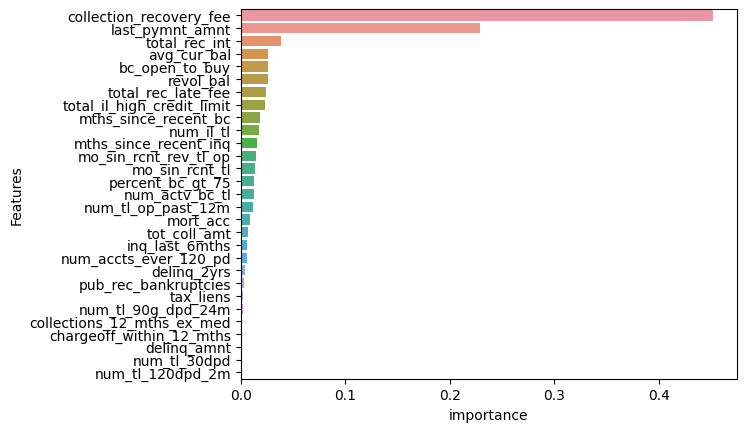

In [237]:
# Plot the feature importances plot
feat_imp = pd.DataFrame()

feat_imp['Features'] = x_train.columns.values
feat_imp['importance'] = rf.feature_importances_

feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(y="Features", x="importance", data=feat_imp);

In [238]:
# First Run
c_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(c_matrix, "\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 28148  10976]
 [  1022 157063]] 

Classification Report:
              precision    recall  f1-score   support

 Charged Off       0.96      0.72      0.82     39124
  Fully Paid       0.93      0.99      0.96    158085

    accuracy                           0.94    197209
   macro avg       0.95      0.86      0.89    197209
weighted avg       0.94      0.94      0.94    197209



In [ ]:
# Drop features that are not associated with the loan status outcome.
feat_to_drop_2 = list(feat_imp[feat_imp["importance"] < 0.01]["Features"].values)

features = (df.select_dtypes(include="number")
              .drop(feat_to_drop, axis=1)
              .drop(feat_to_drop_2, axis=1))

target = df["loan_status"]

x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=1988)

x_train = pd.DataFrame(x_train, columns=features.columns)
x_test = pd.DataFrame(x_test, columns=features.columns)

rf = RandomForestClassifier(random_state=1988)

rf.fit(x_train, y_train);

y_pred = rf.predict(x_test)

In [249]:
# Second Run with lesser columns
c_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(c_matrix, "\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 29086  10038]
 [  1485 156600]] 

Classification Report:
              precision    recall  f1-score   support

 Charged Off       0.95      0.74      0.83     39124
  Fully Paid       0.94      0.99      0.96    158085

    accuracy                           0.94    197209
   macro avg       0.95      0.87      0.90    197209
weighted avg       0.94      0.94      0.94    197209



In [260]:
# Try with StandardScaler for the numerical features
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=1988)

ss = StandardScaler()

x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

x_train = pd.DataFrame(x_train, columns=features.columns)
x_test = pd.DataFrame(x_test, columns=features.columns)

rf = RandomForestClassifier(random_state=1988)

rf.fit(x_train, y_train);

y_pred = rf.predict(x_test)

In [261]:
# Third Run with StandardScaler()
c_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(c_matrix, "\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 30720   8404]
 [  3605 154480]] 

Classification Report:
              precision    recall  f1-score   support

 Charged Off       0.89      0.79      0.84     39124
  Fully Paid       0.95      0.98      0.96    158085

    accuracy                           0.94    197209
   macro avg       0.92      0.88      0.90    197209
weighted avg       0.94      0.94      0.94    197209



After initial run with random forest classifier using just the numerical features, the accuracy of the model seems good at 0.94. All other metrics look decent except for the recall for `Charged Off` loan status. The recall metric of a classification problem is the ratio of number of true positive predictions over the number of actual positive cases. This means out of 100 cases of loan takers who defaulted on the payment, the model is only able to pick out 74 cases. For a loan company, it is not ideal as it means 26 applications for loans are from people who eventually default on their loans. These are considered losses for a loan company. 

Thus, the model must be able to identify people who will default on their loans based on the data available as accurately as possible. In contrast with the recall for `Fully Paid` loan status, it is not as crucial to identify people who eventually fully pay off their loans because these are not considered losses for the company. 

Next, we will train the random forest model again with the categorical features included in. The features are selected first, before the model selection and cross validation. Boosting ensemble models will be run on the Google Colab as they provide GPU suited for boosting training models. Running these ~800,000 observations on a subset of features (numerical features) with random forest on a local machine actually took a while. 

In [ ]:
# BCG EDA
#usecols = ["loan_amnt", "term", "int_rate", "installment", "grade", "sub_grade", "emp_title",
#           "emp_length", "home_ownership", "annual_inc", "verification_status", "issue_d", "loan_status", "purpose",
#           "title", "zip_code", "addr_state", "dti", "earliest_cr_line", "open_acc", "pub_rec",
#           "revol_bal", "revol_util", "total_acc", "initial_list_status", "application_type", "mort_acc", "pub_rec_bankruptcies"]

#df = pd.read_csv("../dataset/lendingclub/accepted_2007_to_2018Q4.csv", nrows = 200, usecols=usecols)